PAPER - A Neural Algorithm of Artistic Style - [PDF](https://arxiv.org/pdf/1508.06576.pdf)

![](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)
* 출력 이미지를 콘텐츠 이미지의 콘텐츠 통계랑(statistic)과 스타일 참조 이미지의 스타일 통계량에 맞춰 최적화시킴

## 이미지 전처리
---

In [2]:
import tensorflow as tf
from tensorflow.keras import preprocessing, utils, applications, optimizers, models
import numpy as np
import matplotlib.pyplot as plt

# tf2 에서 tf1 모델을 사용해야할 때 eagerly를 설정
tf.config.run_functions_eagerly(True)

img_src = "../Image_src/"

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
class ImgPreprocess():

    def __init__(self, combi_shape, base_model=applications.vgg19):
        self.combi_shape = combi_shape
        self.base_model = base_model

    # 이미지 경로 -> (전처리 된) 텐서
    def path2tensor(self, img_path):
        img = preprocessing.image.load_img(img_path,
                                           target_size=self.combi_shape[:2])
        img = preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = self.base_model.preprocess_input(img)
        img = tf.convert_to_tensor(img)
        return img

    # (전처리 된) 텐서 -> (전처리 전) 텐서 이미지
    def tensor2img(self, tensor):
        x = tensor.numpy()
        x = x.reshape(self.combi_shape)
        # vgg 전처리 되돌리기
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        return x

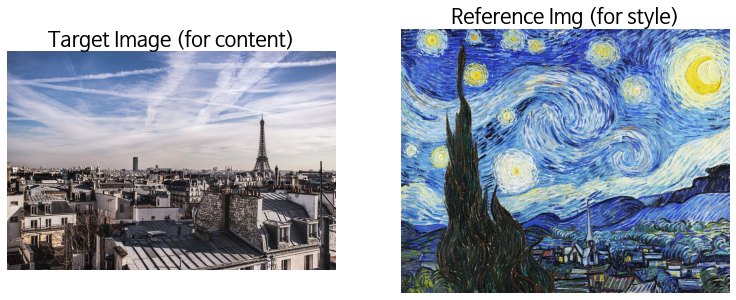

In [5]:
def display_imgs(target_img, ref_img, combination_img=None):
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(target_img)
    plt.title('Target Image (for content)', fontdict={"fontsize":20})
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(ref_img)
    plt.title('Reference Img (for style)', fontdict={"fontsize":20})
    if combination_img is not None:
        plt.subplot(133)
        plt.axis('off')
        plt.imshow(combination_img)
        plt.title('Combination Image', fontdict={"fontsize":20})
    plt.show()
    
target_img = plt.imread(img_src+"Content_img.jpg")
ref_img = plt.imread(img_src+"Style_img.jpg")
display_imgs(target_img, ref_img)

## 모델 준비
---

<p align='center'>
<img  src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzzZ6d%2FbtqtZOLsxg8%2Fdykdt2eKeWaxRFx8iyzEE0%2Fimg.png
' width=500>
</p>


In [6]:
COMBI_SHAPE = (400, 600, 3)
BASE_MODEL = applications.vgg19

#### **특성 추출기**

In [7]:
model = BASE_MODEL.VGG19(include_top=False, weights='imagenet')
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [8]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
extractor = models.Model(inputs=model.inputs, outputs=outputs_dict)

#### **이미지 텐서 준비**

In [9]:
p = ImgPreprocess(COMBI_SHAPE, BASE_MODEL)

# target (content)
target_tensor = p.path2tensor(img_src+"Content_img.jpg")
# reference (style)
refer_tensor = p.path2tensor(img_src+"Style_img.jpg")
# combination 
combi_tensor = tf.Variable(p.path2tensor(img_src+"Content_img.jpg"))

print(target_tensor.shape, refer_tensor.shape, combi_tensor.shape)

(1, 400, 600, 3) (1, 400, 600, 3) (1, 400, 600, 3)


#### **특성 추출**

In [10]:
inputs = tf.concat([target_tensor, refer_tensor, combi_tensor], axis=0)
print('인풋:', inputs.shape)

outputs = extractor(inputs)
print('아웃풋(레이어마다):', len(outputs))

인풋: (3, 400, 600, 3)
아웃풋(레이어마다): 22


In [11]:
for layer_name, output in outputs.items():
    print(layer_name, output.shape)

input_1 (3, 400, 600, 3)
block1_conv1 (3, 400, 600, 64)
block1_conv2 (3, 400, 600, 64)
block1_pool (3, 200, 300, 64)
block2_conv1 (3, 200, 300, 128)
block2_conv2 (3, 200, 300, 128)
block2_pool (3, 100, 150, 128)
block3_conv1 (3, 100, 150, 256)
block3_conv2 (3, 100, 150, 256)
block3_conv3 (3, 100, 150, 256)
block3_conv4 (3, 100, 150, 256)
block3_pool (3, 50, 75, 256)
block4_conv1 (3, 50, 75, 512)
block4_conv2 (3, 50, 75, 512)
block4_conv3 (3, 50, 75, 512)
block4_conv4 (3, 50, 75, 512)
block4_pool (3, 25, 37, 512)
block5_conv1 (3, 25, 37, 512)
block5_conv2 (3, 25, 37, 512)
block5_conv3 (3, 25, 37, 512)
block5_conv4 (3, 25, 37, 512)
block5_pool (3, 12, 18, 512)


In [12]:
# content (전체 구조) - 상위 계층(마지막 계층)에서 추출된다
content_layer = "block5_conv2"
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

## 손실 정의
---

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FboAUdP%2Fbtqt7RHqZqN%2Fx6SxUNLAdhpBw7J5JcK08k%2Fimg.png)

### **| Content 손실**

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FclyRn2%2Fbtqt4yhBuoM%2FA6LcrtitH46HHzqYu40vo1%2Fimg.png)

#### **Content 손실 정의**

In [13]:
# 3개의 이미지에 대한 3개의 Content가 생성
# target 이미지의 content를 가져와야함
# target 과 combination의 Content Loss가 작아져야 함
def get_content_loss(target_content, combi_content):
    return 0.5 * tf.reduce_sum(tf.square(target_content - combi_content))

#### **Content 손실 계산**

In [14]:
# Content는 특정 layer의 아웃풋을 일컫는다.
contents = outputs[content_layer]
print(contents.shape)

# 컨텐츠 손실에 필요한 건 target - combi
target_content = contents[0]
combi_content = contents[2]
print(target_content.shape, combi_content.shape)

# 컨텐츠 손실을 계산 합니다.
content_loss = get_content_loss(target_content, combi_content)
print(f'{content_loss.numpy() :.6f}')

(3, 25, 37, 512)
(25, 37, 512) (25, 37, 512)
0.000000


### **| 스타일 손실**

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FE2teK%2FbtqubfnwDl2%2F9WdiAMbhEKKL9SNNfQqdlk%2Fimg.png)


#### **그램(gram) 매트릭스**

In [15]:
def gram(x):  # x: (h, w, ch)
    x = tf.transpose(x, (2, 0, 1))  # x : (ch, h, w )
    x = tf.reshape(x, (tf.shape(x)[0], -1))  # x: (ch, h*w )
    return tf.matmul(x, tf.transpose(x))

# print(contents[1].shape)
# print(gram(contents[1]).shape)

#### **스타일 손실 정의**

In [16]:
# N : Feature Map(style)의 채널 수
# M : Feature Map(style) 의 resolution(h*w)
# G : Feature Map(reference style)의 Gram Matrix
# A: Feature Map(combination style)의 Gram Matrix
def get_style_loss(refer_style, combi_style):
    N = refer_style.shape[2]
    M = refer_style.shape[0] * refer_style.shape[1]
    G = gram(refer_style)
    A = gram(combi_style)
    return tf.reduce_sum(tf.square(G - A)) / (4 * (N**2) * (M**2))

#### **스타일 손실 계산**

In [17]:
# Style layer로 지정해둔 곳에서 output을 받음
for style_layer in style_layers:
    styles = outputs[style_layer]

    # 스타일 손실에 필요한 건 reference - combi
    refer_style = styles[1]
    combi_style = styles[2]

    # 스타일 손실을 계산 합니다.
    style_loss = get_style_loss(refer_style, combi_style)
    print(style_layer, refer_style.shape, combi_style.shape,f'loss: {style_loss.shape}')

block1_conv1 (400, 600, 64) (400, 600, 64) loss: ()
block2_conv1 (200, 300, 128) (200, 300, 128) loss: ()
block3_conv1 (100, 150, 256) (100, 150, 256) loss: ()
block4_conv1 (50, 75, 512) (50, 75, 512) loss: ()
block5_conv1 (25, 37, 512) (25, 37, 512) loss: ()


#### **| 총 변위 손실**

* 생성된 이미지가 공간적인 연속성을 가지도록 도와준다.
* 픽셀의 격자무늬가 과도하게 나타나는 것을 막아 준다.
* 일종의 규제 항으로 해석할 수 있다.

## 학습
---

### **| 학습을 위한 정리**

In [18]:
def comput_loss(target_tensor,
                refer_tensor,
                combi_tensor,
                alpha=0.01,
                beta=0.00001):
    # 특성 추출
    inputs = tf.concat([target_tensor, refer_tensor, combi_tensor], axis=0)
    outputs = extractor(inputs)

    # 컨텐츠 손실
    contents = outputs[content_layer]
    target_content = contents[0, :, :, :]
    combi_content = contents[2, :, :, :]
    content_loss = get_content_loss(target_content, combi_content)

    # 스타일 손실
    style_loss = tf.zeros(shape=())
    for style_layer in style_layers:
        styles = outputs[style_layer]
        refer_style = styles[1, :, :, :]
        combi_style = styles[2, :, :, :]
        style_loss += get_style_loss(refer_style, combi_style)
    style_loss = style_loss / len(style_layers)

    # 최종 손실 (= alpha * 컨텐츠 손실 + beta * 스타일 손실)
    loss = (alpha * content_loss) + (beta * style_loss)

    return loss

In [19]:
comput_loss(target_tensor, refer_tensor, combi_tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=156333.69>

In [20]:
# Gradient 정의


# tf.function 반복적으로 돌아가는 것에 효율을 높여준다
@tf.function
def compute_loss_grads(target_tensor, refer_tensor, combi_tensor, alpha, beta):
    with tf.GradientTape() as tape:
        loss = comput_loss(target_tensor, refer_tensor, combi_tensor, alpha,beta)
    grads = tape.gradient(loss, combi_tensor)
    return loss, grads


opt = optimizers.SGD(optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0,decay_steps=100,decay_rate=0.96))

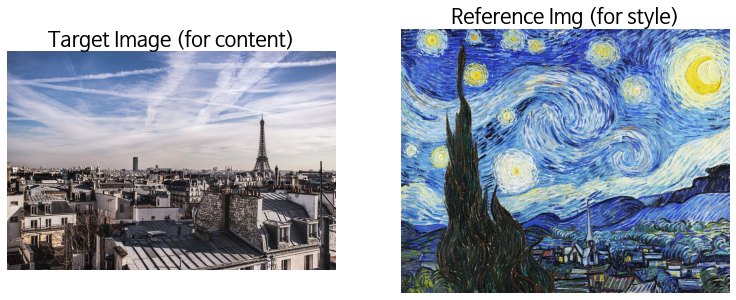

In [21]:
TARGET_SAHPE = (400, 600, 3)
p = ImgPreprocess(TARGET_SAHPE)
# 이미지를 준비한다.
target_path = img_src + "Content_img.jpg"
refer_path =  img_src + "Style_img.jpg"
target_img = plt.imread(target_path)
refer_img = plt.imread(refer_path)
display_imgs(target_img, refer_img)
# 전처리 (tensor)
target_tensor= p.path2tensor(target_path)
refer_tensor= p.path2tensor(refer_path)
combi_tensor= tf.Variable(p.path2tensor(target_path))

### 학습

In [22]:
iters = 5000
for i in range(iters):
    loss, grads = compute_loss_grads(target_tensor, refer_tensor,combi_tensor, alpha=1e-10,beta=4e-6)
    opt.apply_gradients([(grads, combi_tensor)])
    if i % 100 == 0:
        print(f'> iter {i}/{iters} : {loss.numpy():.4f}')

> iter 0/5000 : 62533.4766
> iter 100/5000 : 843.9815
> iter 200/5000 : 505.4553
> iter 300/5000 : 382.6569
> iter 400/5000 : 317.6564
> iter 500/5000 : 276.5117
> iter 600/5000 : 247.5533
> iter 700/5000 : 225.9754
> iter 800/5000 : 209.2060
> iter 900/5000 : 195.7418
> iter 1000/5000 : 184.6954
> iter 1100/5000 : 175.4258
> iter 1200/5000 : 167.5154
> iter 1300/5000 : 160.6800
> iter 1400/5000 : 154.7221
> iter 1500/5000 : 149.4762
> iter 1600/5000 : 144.8117
> iter 1700/5000 : 140.6465
> iter 1800/5000 : 136.9048
> iter 1900/5000 : 133.5287
> iter 2000/5000 : 130.4743
> iter 2100/5000 : 127.6898
> iter 2200/5000 : 125.1447
> iter 2300/5000 : 122.8092
> iter 2400/5000 : 120.6659
> iter 2500/5000 : 118.6884
> iter 2600/5000 : 116.8656
> iter 2700/5000 : 115.1793
> iter 2800/5000 : 113.6148
> iter 2900/5000 : 112.1620
> iter 3000/5000 : 110.8090
> iter 3100/5000 : 109.5492
> iter 3200/5000 : 108.3701
> iter 3300/5000 : 107.2680
> iter 3400/5000 : 106.2348
> iter 3500/5000 : 105.2664
> 

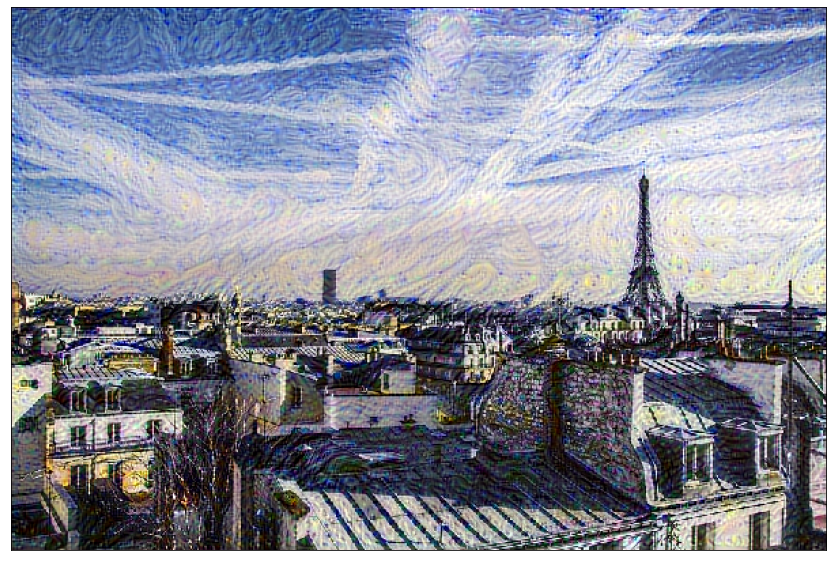

In [24]:
# 결과를 본다.
result = p.tensor2img(combi_tensor)
#display_imgs(target_img, refer_img, result)
plt.figure(figsize=(18,10));plt.xticks([]);plt.yticks([])
plt.imshow(result)
plt.savefig('result02.png')